## Extraction and removal of silence

In [ ]:
import os
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc

def extract_and_eliminate_silence(input_folder, output_folder, silence_threshold=0.001):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith('.wav'):
            filepath = os.path.join(input_folder, filename)
            label = filename.split('.')[0]  # Extract label from filename
            samplerate, data = wav.read(filepath)  # Read audio file
            mfcc_feat = mfcc(data, samplerate, winlen=0.025, winstep=0.01, numcep=13)  # Extract MFCC features with 13 components
            
            # Calculate energy for each frame
            energy = np.log(np.sum(np.square(mfcc_feat), axis=1))

            # Concatenate MFCC with energy
            mfcc_with_energy = np.hstack((mfcc_feat, np.expand_dims(energy, axis=1)))

            # Eliminate frames with energy below the threshold
            mfcc_without_silence = mfcc_with_energy[energy > silence_threshold]

            # Write MFCC features without silence to new file
            output_filename = os.path.join(output_folder, f'{label}.txt')
            np.savetxt(output_filename, mfcc_without_silence)


# Example usage:
input_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2 - Copy\langues\Arabe"
output_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2 - Copy\mfcc\arabe"
extract_and_eliminate_silence(input_folder, output_folder)


## Creation of the train and test sets

In [ ]:
import os
import random
import shutil

# Define the paths to your folders
source_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2 - Copy\mfcc\arabe"
training_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2 - Copy\train\arabe"
test_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2 - Copy\test\arabe"

# Ensure the training and test folders exist
os.makedirs(training_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get the list of files in the source folder
files = os.listdir(source_folder)

# Shuffle the list of files randomly
random.shuffle(files)

# Calculate the number of files to move to the training set
num_files_training = len(files) * 2 // 3

# Move files to the training set
for i in range(num_files_training):
    file_to_move = files.pop()
    shutil.move(os.path.join(source_folder, file_to_move), os.path.join(training_folder, file_to_move))

# Move the rest of the files to the test set
for file_to_move in files:
    shutil.move(os.path.join(source_folder, file_to_move), os.path.join(test_folder, file_to_move))

print("Files moved successfully.")


## Creation of GMM models for each language

In [ ]:
import os
import joblib
import numpy as np
from sklearn.mixture import GaussianMixture

# Function to pad or truncate each frame to have exactly 14 features
def preprocess_frames(frames):
    num_features = 14
    for i in range(len(frames)):
        # If the frame has fewer than 14 features, pad it with zeros
        if len(frames[i]) < num_features:
            frames[i] += [0] * (num_features - len(frames[i]))
        # If the frame has more than 14 features, truncate it
        elif len(frames[i]) > num_features:
            frames[i] = frames[i][:num_features]
    return frames

# Folder containing training files
train_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de locuteur\mfcc\english\Hommes\train\eng_H6"

# List to store training data
training_data = []

# Read training files from the folder
for file in os.listdir(train_folder):
    if file.endswith(".txt"):  # Assuming training files are in TXT format
        file_path = os.path.join(train_folder, file)
        # Load training data from TXT files
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # Convert each line to a list of floats and preprocess frames to ensure 14 features
            data = [list(map(float, line.strip().split())) for line in lines]
            data = preprocess_frames(data)
            training_data.extend(data)

# Convert training data to a numpy array
X_train = np.array(training_data)

print("X_train shape:", X_train.shape)


# Numbers of components
num_components = [16, 64, 256]

# List to store trained GMM models
gmm_models = []

# Iterate over each number of components
for n in num_components:
    # Initialize GMM model
    gmm = GaussianMixture(n_components=n, random_state=42)
    # Fit the model to the training data
    gmm.fit(X_train)
    # Append the trained model to the list
    gmm_models.append(gmm)

# Folder to save trained models
save_folder = r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de locuteur\gmm\english\homme\eng_H6"

# Save trained GMM models
for i, gmm in enumerate(gmm_models):
    model_filename = os.path.join(save_folder, f"gmm_model_{num_components[i]}.gmm")
    joblib.dump(gmm, model_filename)

print("GMM models saved successfully.")


## Test Folders / GMM models

In [3]:
models_folders = {
    'arabe': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\arabe",
    'francais': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\francais",
    'english' : r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\english",
    'italien': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\italien",
    'japanese': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\japanese",
    'romanian': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\romanian",
    'spanish': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\gmm\spanish",
}

# Define test data folders
test_folders = {
    'arabe': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\arabe\test",
    'francais': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\francais\test",
    'english': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\english\test",
    'italien': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\italien\test",
    'japanese': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\japanese\test",
    'romanian': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\romanian\test",
    'spanish': r"C:\Users\oumay\OneDrive\Bureau\NLP\Reconnaissance de langue 2\train_test\spanish\test",
}


## 

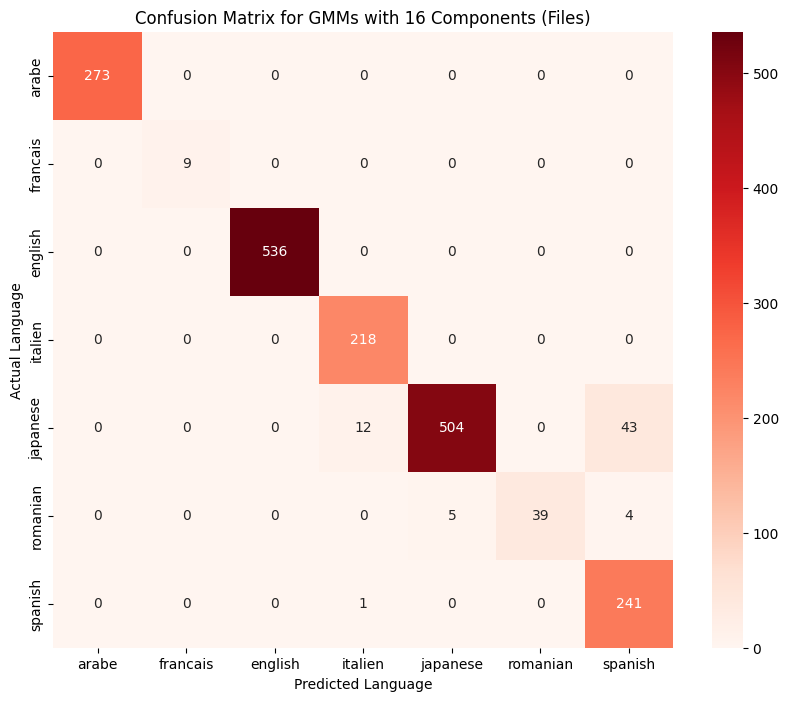

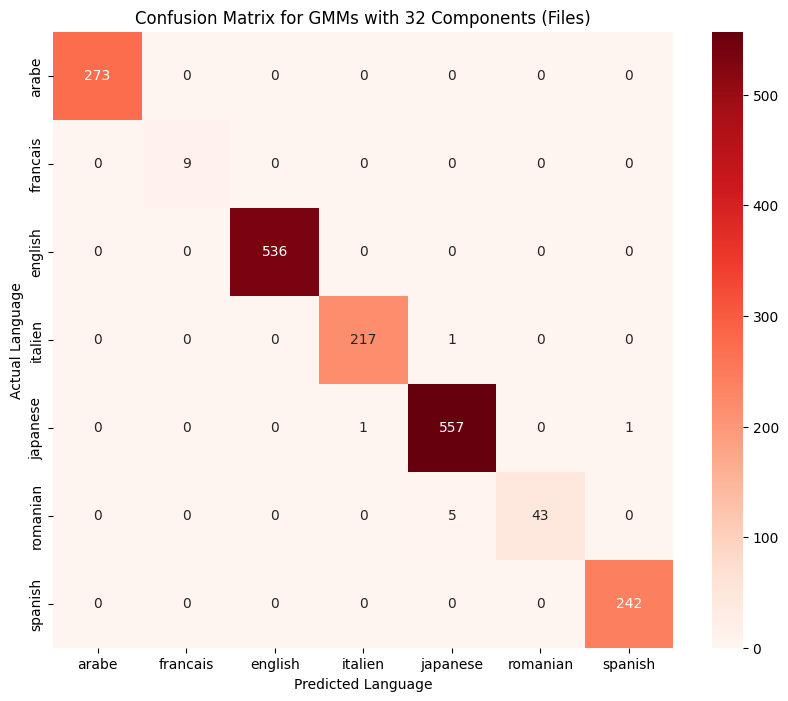

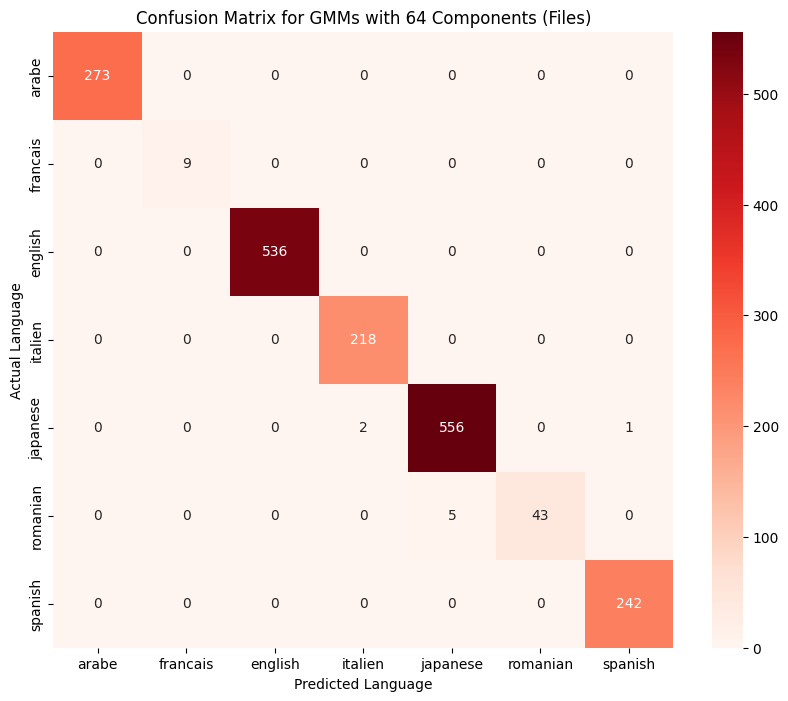

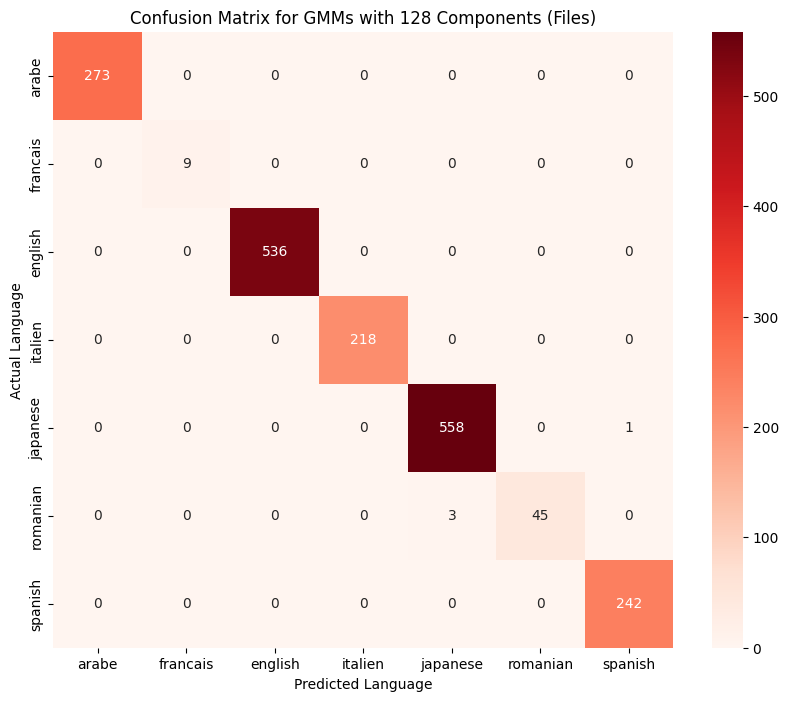

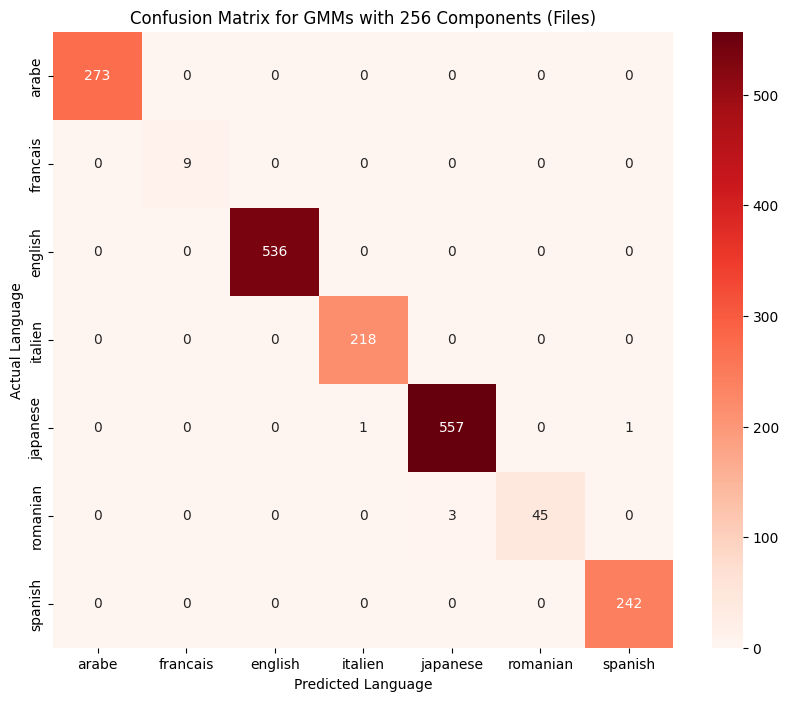

In [2]:
import os
import joblib
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


gmm_models = {}

for lang, folder in models_folders.items():
    lang_models = {}
    for file in os.listdir(folder):
        if file.endswith(".gmm") or file.endswith(".joblib"):
            model_path = os.path.join(folder, file)
            n_components = int(file.split("_")[-1].split(".")[0])
            gmm = joblib.load(model_path)
            lang_models[n_components] = gmm
    gmm_models[lang] = lang_models
    
    
# Iterate over each GMM size
for n_components in [16, 32, 64, 128, 256]:
    # Initialize lists to store actual and predicted languages for files
    actual_languages = []
    predicted_languages = []

    # Iterate through test data folders
    for actual_lang, test_folder in test_folders.items():
        for file in os.listdir(test_folder):
            if file.endswith(".mfcc") or file.endswith(".txt"):
                file_path = os.path.join(test_folder, file)
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    data = [list(map(float, line.strip().split())) for line in lines]
                    cumulative_scores = defaultdict(float)

                    # Iterate through GMM models and calculate scores for the specified component size
                    for lang, models in gmm_models.items():
                        # Use the specific GMM size
                        gmm = models.get(n_components)
                        if gmm is not None:
                            score = gmm.score(data)
                            cumulative_scores[lang] += score  # Accumulate scores

                    # Determine the best prediction based on the cumulative scores
                    best_lang = max(cumulative_scores, key=cumulative_scores.get)
                    actual_languages.append(actual_lang)
                    predicted_languages.append(best_lang)

    # Create confusion matrix for the current component size
    conf_matrix = confusion_matrix(actual_languages, predicted_languages, labels=list(models_folders.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=list(models_folders.keys()), yticklabels=list(models_folders.keys()))
    plt.xlabel('Predicted Language')
    plt.ylabel('Actual Language')
    plt.title(f'Confusion Matrix for GMMs with {n_components} Components (Files)')
    plt.show()
